Vamos a intentar usar el código de la notebook `Priorizacion_con_red_chiquita` para la red completa de la notebook `05` o alguna subred interesante de ella.

In [1]:
%run imports.py
%run utils.py
%run leer_red.py


#########################################################
#
# OJO: Esto tiene un pico fuerte de uso de RAM! ~12 Gb
#
#########################################################

TENGO_MUCHA_RAM = True

#########################################################

/home/juan/miniconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
%%time

red = leer_subred_nx() # Tarda ~20s
red_df = leer_subred_df()

print(f"{red.number_of_nodes():,} nodos en la red")
print(f"{red.number_of_edges():,} enlaces en la red")

37,823 nodos en la red
226,723 enlaces en la red
CPU times: user 19.9 s, sys: 264 ms, total: 20.2 s
Wall time: 20.2 s


In [37]:
import sys
from humanfriendly import format_size


def buscar_fenos_similares_por_LS(red, nodos_entrada):
    """Busca fenotipos similares en una red de networkx, entrando por los
    nodos_entrada. Devuelve un pandas.DataFrame de resultados."""
    
    adj_matrix = nx.adj_matrix(red).toarray()
    
    ram_a_usar = format_size(sys.getsizeof(adj_matrix))
    print(f"WARNINIG: va a usar {ram_a_usar} de RAM")
    
    # En este paso la matriz original ocupa la RAM:
    adj_matrix_t = torch.FloatTensor(adj_matrix)

    labels = [0 if nodo in nodos_entrada else -1 for nodo in red.nodes()]
    labels_t = torch.LongTensor(labels)
    
    # Al instanciarse LabelSpreading, normaliza la matriz y
    # ahora hay dos matrices en memoria:
    label_spreading = LabelSpreading(adj_matrix_t)    
    label_spreading.fit(labels_t, alpha=.8)

    # Borramos las referencias a las dos matrices, este paso libera la RAM:
    del adj_matrix_t
    label_spreading.norm_adj_matrix = None
    
    resultado = pd.DataFrame({
        "nodos_entrada": "|".join(nodos_entrada),
        "nodo_salida": red.nodes(),
        "prediccion": label_spreading.flat_predictions,
    })
    
    return resultado.sort_values(by=["prediccion"], ascending=False)


resultados = pd.DataFrame()
fenos_entrada = red_df.fenotipo.value_counts().head(20).index

if TENGO_MUCHA_RAM:
    
    for feno in fenos_entrada:
        print("-" * 20 + "\n" + feno)
        resultado = buscar_fenos_similares_por_LS(red, nodos_entrada=[feno])
        resultados = pd.concat([resultados, resultado], axis=0, ignore_index=True)
        
resultados = resultados.reset_index(drop=True)

--------------------
General cognitive ability
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▍         | 39/1000 [00:04<02:01,  7.90it/s]


The method stopped after 39 iterations, variation=0.0009.
--------------------
Schizophrenia
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▍         | 39/1000 [00:04<01:45,  9.10it/s]


The method stopped after 39 iterations, variation=0.0010.
--------------------
Type 2 diabetes
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▍         | 38/1000 [00:05<02:20,  6.85it/s]


The method stopped after 38 iterations, variation=0.0009.
--------------------
Breast cancer
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▍         | 38/1000 [00:05<02:12,  7.24it/s]


The method stopped after 38 iterations, variation=0.0010.
--------------------
Intelligence (MTAG)
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▍         | 38/1000 [00:06<02:42,  5.93it/s]


The method stopped after 38 iterations, variation=0.0009.
--------------------
Multiple sclerosis
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▍         | 38/1000 [00:04<02:00,  7.97it/s]


The method stopped after 38 iterations, variation=0.0008.
--------------------
Coronary artery disease
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:05<02:36,  6.15it/s]


The method stopped after 36 iterations, variation=0.0010.
--------------------
Systemic lupus erythematosus
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 37/1000 [00:06<02:46,  5.80it/s]


The method stopped after 37 iterations, variation=0.0008.
--------------------
Crohn's disease
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 37/1000 [00:05<02:25,  6.63it/s]


The method stopped after 37 iterations, variation=0.0008.
--------------------
Bipolar disorder
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 37/1000 [00:06<02:47,  5.75it/s]


The method stopped after 37 iterations, variation=0.0008.
--------------------
Autism spectrum disorder or schizophrenia
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▍         | 38/1000 [00:06<02:46,  5.78it/s]


The method stopped after 38 iterations, variation=0.0008.
--------------------
Colorectal cancer
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:06<02:42,  5.94it/s]


The method stopped after 36 iterations, variation=0.0010.
--------------------
Inflammatory bowel disease
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:05<02:38,  6.09it/s]


The method stopped after 36 iterations, variation=0.0010.
--------------------
Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:04<02:00,  7.97it/s]


The method stopped after 36 iterations, variation=0.0009.
--------------------
Ulcerative colitis
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:05<02:29,  6.43it/s]


The method stopped after 36 iterations, variation=0.0009.
--------------------
Prostate cancer
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:06<02:50,  5.67it/s]


The method stopped after 36 iterations, variation=0.0008.
--------------------
Atrial fibrillation
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:06<02:47,  5.76it/s]


The method stopped after 36 iterations, variation=0.0008.
--------------------
Hypertension
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 35/1000 [00:06<02:47,  5.75it/s]


The method stopped after 35 iterations, variation=0.0009.
--------------------
Psoriasis
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:06<02:45,  5.82it/s]


The method stopped after 36 iterations, variation=0.0008.
--------------------
Major depressive disorder
WARNINIG: va a usar 11.44 GB de RAM


Iteración:   4%|▎         | 36/1000 [00:04<02:02,  7.88it/s]


The method stopped after 36 iterations, variation=0.0009.


In [38]:
feno_a_categoria = red_df.set_index("fenotipo").categoria_fenotipo.to_dict()
resultados["es_fenotipo"] = resultados.nodo_salida.isin(red_df.fenotipo)
resultados["categoria_fenotipo"] = resultados.nodo_salida.map(feno_a_categoria)
resultados["prediccion_log10"] = resultados.prediccion.map(np.log10)
resultados = resultados.query("nodos_entrada != nodo_salida")

resultados.head(5)

/home/juan/miniconda3/lib/python3.7/site-packages/pandas/core/base.py:1145: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)


,nodos_entrada,nodo_salida,prediccion,es_fenotipo,categoria_fenotipo,prediccion_log10
1,General cognitive ability,Intelligence (MTAG),0.019433,True,Neuro/Cogni/Emo,-1.711455
2,General cognitive ability,RALYL,0.009102,False,NaN,-2.040883
3,General cognitive ability,rs11629297-?,0.008835,False,NaN,-2.053770
4,General cognitive ability,rs76034074-?,0.008835,False,NaN,-2.053770
5,General cognitive ability,rs547851394-?,0.008835,False,NaN,-2.053770


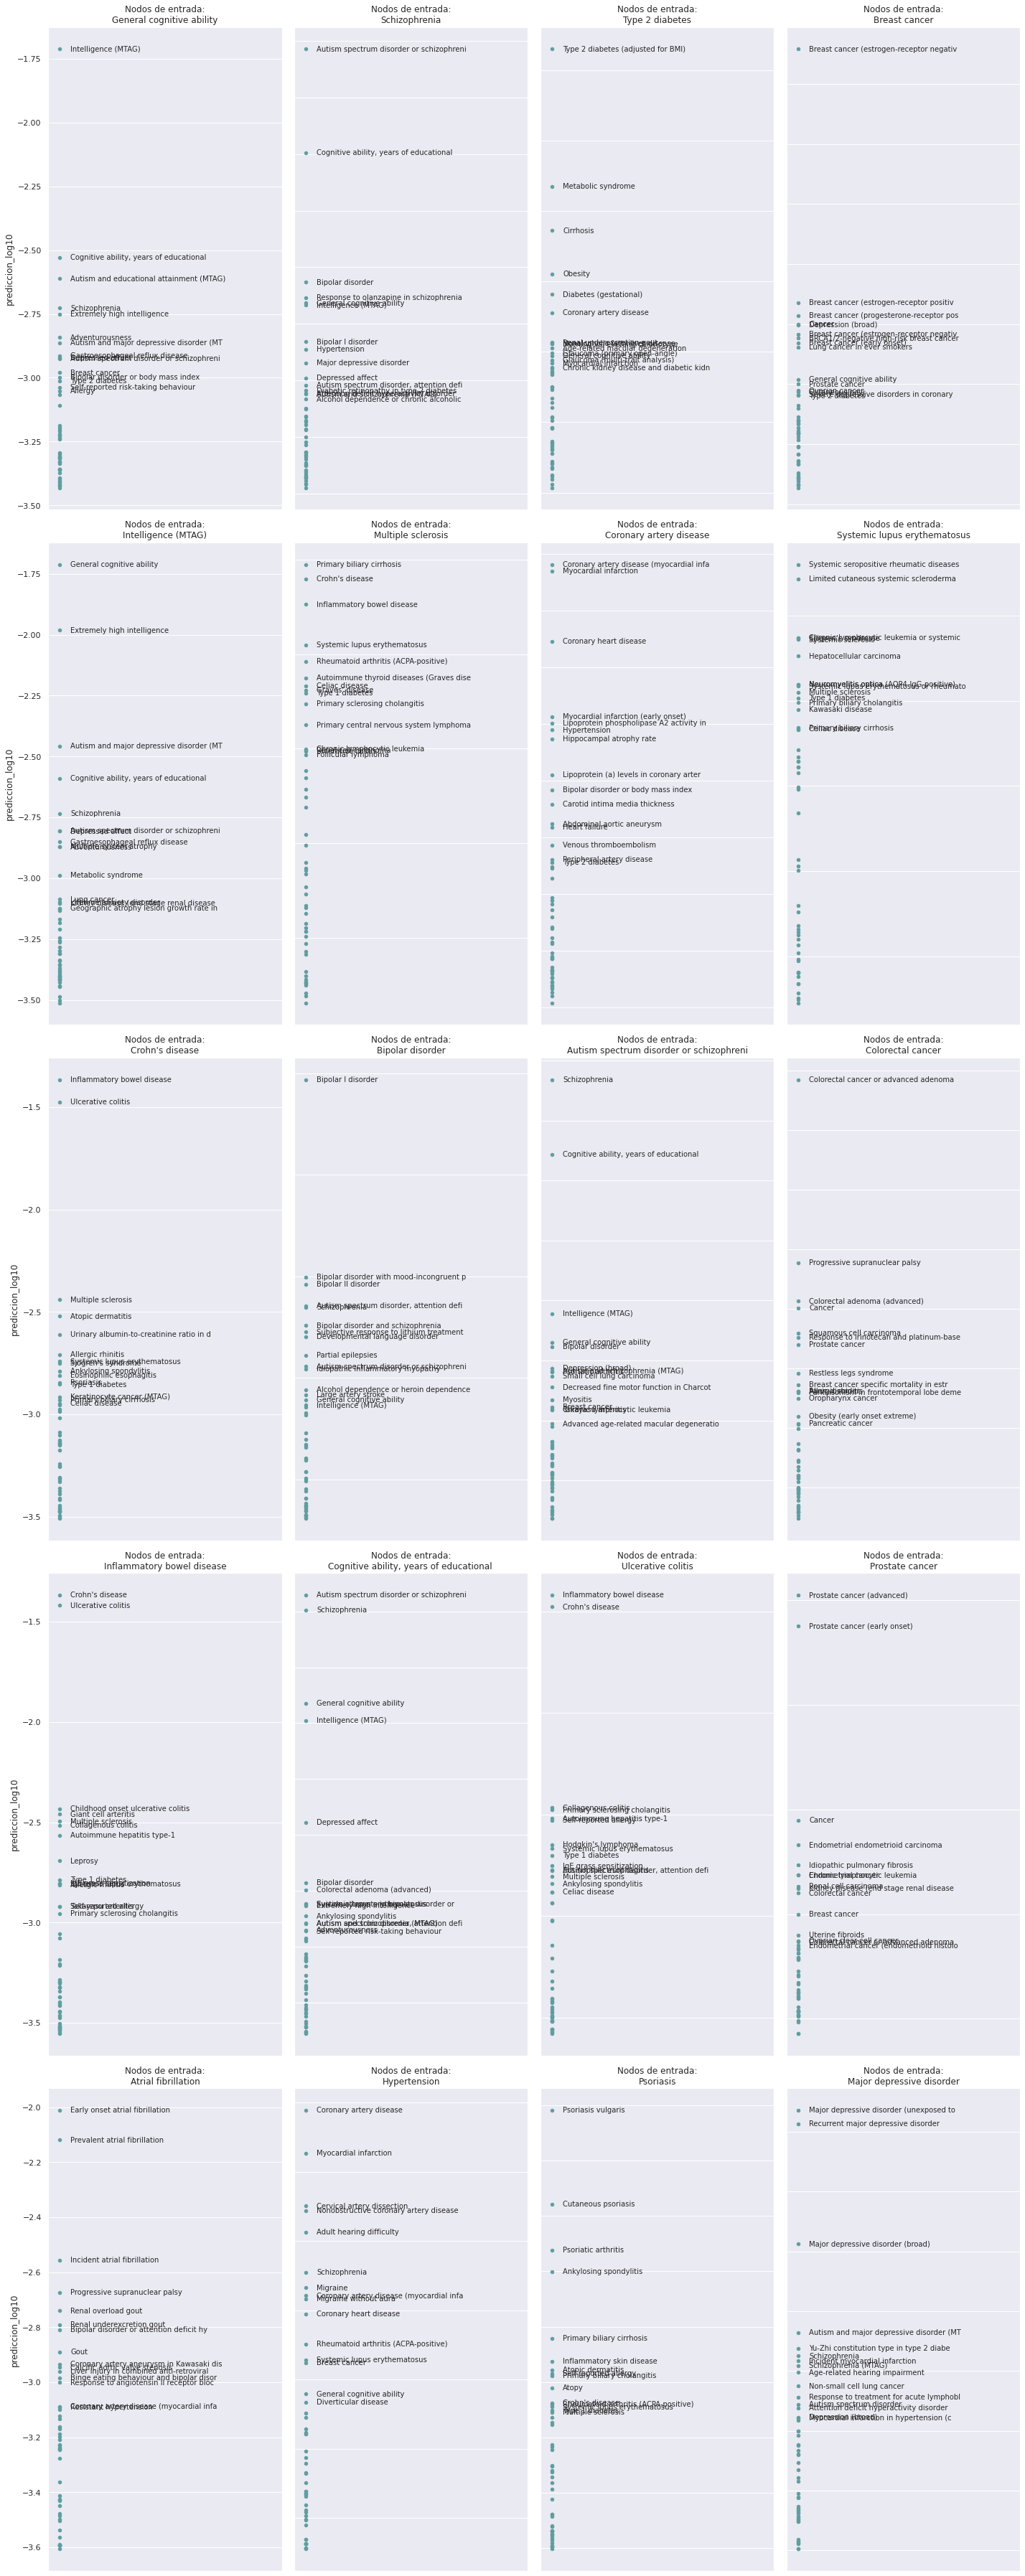

In [86]:
n_plots = len(fenos_entrada)
n_cols = 4
plot_width = 5
plot_height = 10
n_rows = (n_plots//n_cols)+1
figsize = (plot_width * n_cols, plot_height * n_rows)

for i, nodo_entrada in enumerate(fenos_entrada):
    
    df = resultados.query("nodos_entrada == @nodo_entrada")
    df = df.query("es_fenotipo").reset_index()
    df["zero"] = 0
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    
    df.head(50).plot.scatter(ax=ax, x="zero", y="prediccion_log10", color="CadetBlue", figsize=figsize, sharey=True)
    ax.set_title(f"Nodos de entrada:\n{nodo_entrada[:40]}")
    ax.set_xticks([])
    ax.set_xlabel(None)
    ax.set_xlim((-1, 20))
    
    for j, row in df.head(15).iterrows():
        x, y = 1, row.prediccion_log10
        ax.annotate(row.nodo_salida[:40], (x, y), verticalalignment="center", fontsize=10)
        
plt.tight_layout()
plt.savefig("results/test.png", dpi=110)